# Demonstration of MUSE

This is a demonstration of MUSE analysis on a multi-modality simulated data.

Altschuler & Wu Lab 2020.

Software provided as is under MIT License.

## Import packages

In [1]:
import muse_sc as muse
import simulation_tool.multi_modal_simulation as simulation

import phenograph
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
np.random.seed(0)

## Generate simulation data


Simulation parameters

In [2]:
latent_dim = 100
num_cluster = 10
sample_size = 1000
latent_code_dim = 30
observed_data_dim = 500
sigma_1 = 0.1  
sigma_2 = 0.1
decay_coef_1 = 0.5 
decay_coef_2 = 0.1
merge_prob = 0.7



Use simulation tool to generate multi-modality data

In [3]:
data = simulation.multi_modal_simulator(num_cluster, sample_size,
                                        observed_data_dim, observed_data_dim,
                                        latent_code_dim,
                                        sigma_1, sigma_2,
                                        decay_coef_1, decay_coef_2,
                                        merge_prob)
data_a = data['data_a_dropout']
data_b = data['data_b_dropout']
label_a = data['data_a_label']
label_b = data['data_b_label']
label_true = data['true_cluster']

## Analyses based on single modality

Learn features from single modality

In [4]:
view_a_feature = PCA(n_components=latent_dim).fit_transform(data_a)
view_b_feature = PCA(n_components=latent_dim).fit_transform(data_b)

Perform clustering using PhenoGraph

In [5]:
view_a_label, _, _ = phenograph.cluster(view_a_feature)
view_b_label, _, _ = phenograph.cluster(view_b_feature)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.10591483116149902 seconds
Jaccard graph constructed in 0.12598395347595215 seconds
Wrote graph to binary file in 0.21828293800354004 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.524911
Louvain completed 21 runs in 0.4152088165283203 seconds
PhenoGraph complete in 0.8746728897094727 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.1064918041229248 seconds
Jaccard graph constructed in 0.12385201454162598 seconds
Wrote graph to binary file in 0.195847749710083 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.646846
Louvain completed 21 runs in 0.37131476402282715 seconds
PhenoGraph complete in 0.8060569763183594 seconds


## Combined analysis using MUSE

MUSE learns the joint latent representation

In [6]:
muse_feature, reconstruct_x, reconstruct_y, \
latent_x, latent_y = muse.muse_fit_predict(data_a,
                                           data_b,
                                           view_a_label,
                                           view_b_label,
                                           latent_dim=100,
                                           n_epochs=500,
                                           lambda_regul=5,
                                           lambda_super=5)

++++++++++ MUSE for multi-modality single-cell analysis ++++++++++
MUSE initialization
epoch: 0, 	 total loss: 1595.03711,	 reconstruction loss: 593.55298,	 sparse penalty: 200.29683
epoch: 50, 	 total loss: 1099.16089,	 reconstruction loss: 154.48636,	 sparse penalty: 188.93491
epoch: 100, 	 total loss: 1042.67651,	 reconstruction loss: 154.02176,	 sparse penalty: 177.73096
epoch: 150, 	 total loss: 987.22809,	 reconstruction loss: 152.78545,	 sparse penalty: 166.88852
epoch: 0, 	 total loss: 950.75769,	 reconstruction loss: 150.49942,	 sparse penalty: 156.43390,	 x triplet: 1.79524,	 y triplet: 1.82251
epoch: 50, 	 total loss: 895.18176,	 reconstruction loss: 148.52904,	 sparse penalty: 146.37599,	 x triplet: 1.56031,	 y triplet: 1.39424
epoch: 100, 	 total loss: 842.55505,	 reconstruction loss: 146.03760,	 sparse penalty: 136.70886,	 x triplet: 1.31826,	 y triplet: 1.27637
epoch: 150, 	 total loss: 793.20294,	 reconstruction loss: 143.89842,	 sparse penalty: 127.43238,	 x triplet: 1

PhenoGraph clustering

In [7]:
muse_label, _, _ = phenograph.cluster(muse_feature)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.11139416694641113 seconds
Jaccard graph constructed in 0.13368582725524902 seconds
Wrote graph to binary file in 0.06698203086853027 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.920569
Louvain completed 21 runs in 0.36715102195739746 seconds
PhenoGraph complete in 0.6885502338409424 seconds


## Visualization of latent spaces 
Latent spaces of single-modality features or MUSE features were visualized using tSNE, with ground truth cluster labels.

Cluster accuries were quantified using adjusted Rand index (ARI). ARI = 1 indicates perfectly discover true cell identities.

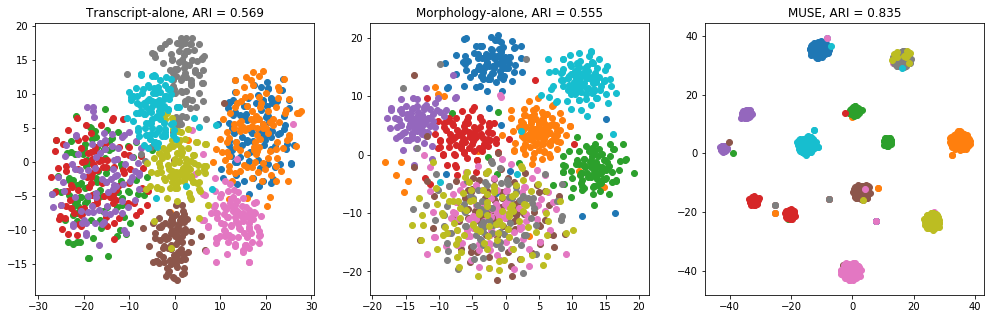

In [8]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
X_embedded = TSNE(n_components=2).fit_transform(view_a_feature)
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('Transcript-alone, ARI = %01.3f' % adjusted_rand_score(label_true, view_a_label))

plt.subplot(1, 3, 2)
X_embedded = TSNE(n_components=2).fit_transform(view_b_feature)
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('Morphology-alone, ARI = %01.3f' % adjusted_rand_score(label_true, view_b_label))

plt.subplot(1, 3, 3)
X_embedded = TSNE(n_components=2).fit_transform(muse_feature)
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('MUSE, ARI = %01.3f' % adjusted_rand_score(label_true, muse_label))